📈 **Forecasting 2024 Revenue Using Trained XGBoost Residual Model**

This notebook extends our residual-based modeling pipeline by generating monthly revenue forecasts for 2024.

🔍 Objective
Leverage trained XGBoost models (base + residual) to forecast monthly revenue per product (Alpha, Beta, Gamma, Delta) using engineered features and learned error corrections.

🎯 Key Steps
Generate monthly dates for 2024

Create matching features (calendar, product flags, interactions)

Apply trained models to forecast revenue

Export results for Power BI visualization

💡 Business Use
This forecast supports:

Monthly budgeting and revenue planning

Comparing forecast performance across Prophet, SARIMA, and XGBoost

Early identification of potential over- or under-performance

In [138]:
import pandas as pd

In [139]:
# --- PATHS & FLAGS ----------------------------------------------------
from pathlib import Path
import pandas as pd, requests, io

# Base URL of my GitHub repo (raw view)
BASE_URL = ("https://raw.githubusercontent.com/"
            "Eugine-Srb/Sales-Forecasting_2024-Project/main/")


DATA_PROC_URL = BASE_URL + "data/processed/"     # for imports

# Local fallback folders (never pushed)
EXPORT_DIR = Path("../scratch_outputs")
EXPORT_DIR.mkdir(exist_ok=True)

# Master switch — keep False unless *really* want to re-export
SAVE_OUTPUTS = False

In [140]:
def load_processed(name: str) -> pd.DataFrame:
    """Load a frozen CSV straight from GitHub raw URL."""
    url = DATA_PROC_URL + name
    return pd.read_csv(url, low_memory=False)   # pandas handles https URLs

In [141]:
# Load the Product Sales Interpolated dataset

full_df = load_processed("11_XGBoost_ML_Results_For_PowerBI.csv")

In [142]:
print("✅  Shape:", full_df.shape)
display(full_df.head())

✅  Shape: (240, 39)


,Date,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag,Product_Code,Month_Num,Interpolated_Flag_Num,...,Residual_Predicted,Final_Predicted,Final_Residual,Residual_Predicted_CV,Final_Predicted_CV,Final_Residual_CV,Residual_Predicted_CV_Optimized,Final_Predicted_CV_Optimized,Final_Residual_CV_Optimized,Product
0,2019-01-01,146.0,100.151629,1,2019,14622.137902,False,0,1,0,...,-5.877696,14622.4490,-0.311316,8.623343,14636.950195,-14.812293,36.707298,14665.034180,-42.896277,Alpha
1,2019-01-01,142.0,146.322254,1,2019,20777.760060,False,1,1,0,...,57.176548,20777.4770,0.283498,226.235626,20946.537109,-168.777049,53.405708,20773.707031,4.053029,Beta
2,2019-01-01,124.0,65.615260,1,2019,8136.292207,False,2,1,0,...,-62.212612,8137.9450,-1.652617,-330.010071,7870.146973,266.145235,-70.383858,8129.773438,6.518770,Delta
3,2019-01-01,133.0,105.676289,1,2019,14054.946477,False,3,1,0,...,-46.851395,14051.4375,3.508977,-212.908417,13885.380859,169.565618,-38.907566,14059.381836,-4.435359,Gamma
4,2019-02-01,140.0,52.709599,2,2019,7379.343895,False,2,2,0,...,5.507827,7378.8496,0.494286,-5.368661,7367.973145,11.370751,-45.138649,7328.203125,51.140770,Delta


In [143]:
import xgboost as xgb, io, requests

def load_xgb_model(filename: str, repo_root="..") -> xgb.XGBRegressor:
    """
    Load an XGB model from ../models if it exists locally,
    otherwise stream it from the GitHub raw URL.
    """
    local_path = Path(repo_root) / "models" / filename
    bst = xgb.XGBRegressor()

    if local_path.exists():
        bst.load_model(local_path)
        print(f"✅ loaded {filename} from {local_path}")
    else:
        url = ("https://raw.githubusercontent.com/"
               "Eugine-Srb/Sales-Forecasting_2024-Project/main/models/"
               f"{filename}")
        payload = bytearray(requests.get(url).content)  # ← raw bytes
        bst.load_model(payload)
        print(f"🌐 fetched {filename} from GitHub raw URL")

    return bst

In [144]:
# Import XGB Models 
xgb_model_base      = load_xgb_model("xgb_model_base.json")
xgb_model_residual  = load_xgb_model("xgb_model_residual.json")

🌐 fetched xgb_model_base.json from GitHub raw URL
🌐 fetched xgb_model_residual.json from GitHub raw URL


In [145]:
xgb_model_residual

XGBRegressor(base_score='-4.770134E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'int', 'int', 'int', 'i', 'i',
                            'i', 'float', 'float', 'float', 'float', 'float',
                            'float', 'int', 'int', 'int', 'int'...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [146]:
# Monthly start dates for 2024
future_dates = pd.date_range(start="2024-01-01", end="2024-12-01", freq="MS")
forecast_base = pd.DataFrame({"Date": future_dates})

In [147]:
#  Add Calendar-Based Features
forecast_base['Month'] = forecast_base['Date'].dt.month
forecast_base['Year'] = forecast_base['Date'].dt.year
forecast_base['Quarter'] = forecast_base['Date'].dt.quarter
forecast_base['DayOfYear'] = forecast_base['Date'].dt.dayofyear
forecast_base['Day'] = forecast_base['Date'].dt.day
forecast_base['Weekday'] = forecast_base['Date'].dt.weekday
forecast_base['IsWeekend'] = forecast_base['Weekday'].isin([5, 6]).astype(int)

In [148]:
# Create One Row Per Product
products = ['Beta', 'Gamma', 'Delta', 'Alpha']
forecast_full = pd.concat([
    forecast_base.assign(Product=prod) for prod in products
], ignore_index=True)

# Add product dummies like Product_Beta, Product_Gamma, etc.
forecast_full['Product_Beta'] = (forecast_full['Product'] == 'Beta').astype(int)
forecast_full['Product_Gamma'] = (forecast_full['Product'] == 'Gamma').astype(int)
forecast_full['Product_Delta'] = (forecast_full['Product'] == 'Delta').astype(int)

In [149]:
# Price and Sold interactions (can be placeholder averages or assumed constants)
avg_unit_price = full_df['Unit_Price'].mean()
avg_units_sold = full_df['Units_Sold'].mean()

forecast_full['Price_x_Beta'] = avg_unit_price * forecast_full['Product_Beta']
forecast_full['Price_x_Gamma'] = avg_unit_price * forecast_full['Product_Gamma']
forecast_full['Price_x_Delta'] = avg_unit_price * forecast_full['Product_Delta']

forecast_full['Sold_x_Beta'] = avg_units_sold * forecast_full['Product_Beta']
forecast_full['Sold_x_Gamma'] = avg_units_sold * forecast_full['Product_Gamma']
forecast_full['Sold_x_Delta'] = avg_units_sold * forecast_full['Product_Delta']

# Month interactions
forecast_full['Month_x_Beta'] = forecast_full['Month'] * forecast_full['Product_Beta']
forecast_full['Month_x_Gamma'] = forecast_full['Month'] * forecast_full['Product_Gamma']
forecast_full['Month_x_Delta'] = forecast_full['Month'] * forecast_full['Product_Delta']

# Use average values from historical data
forecast_full['Units_Sold'] = full_df['Units_Sold'].mean()
forecast_full['Unit_Price'] = full_df['Unit_Price'].mean()
forecast_full['Interpolated_Flag_Num'] = 0  # future data is not interpolated

In [150]:
features = [
    'Units_Sold', 'Unit_Price', 'Month', 'Year', 'Interpolated_Flag_Num',
    'Product_Beta', 'Product_Delta', 'Product_Gamma',
    'Price_x_Beta', 'Price_x_Gamma', 'Price_x_Delta',
    'Sold_x_Beta', 'Sold_x_Gamma', 'Sold_x_Delta',
    'Day', 'Weekday', 'IsWeekend', 'Quarter', 'DayOfYear',
    'Month_x_Beta', 'Month_x_Gamma', 'Month_x_Delta'
]
X_future = forecast_full[features]

In [151]:
# Load models if not already
# from joblib import load
# xgb_model_base = load("xgb_model_base.pkl")
# xgb_model_residual = load("xgb_model_residual.pkl")

# Predict
forecast_full['Base_Predicted'] = xgb_model_base.predict(X_future)
forecast_full['Residual_Predicted'] = xgb_model_residual.predict(X_future)
forecast_full['Final_Forecast'] = (forecast_full['Base_Predicted'] + forecast_full['Residual_Predicted'])

In [152]:
forecast_final = forecast_full[['Date', 'Product', 'Final_Forecast']]

In [153]:
forecast_final

,Date,Product,Final_Forecast
0,2024-01-01,Beta,11650.265625
1,2024-02-01,Beta,12125.195312
2,2024-03-01,Beta,12058.088867
3,2024-04-01,Beta,11666.036133
4,2024-05-01,Beta,11877.171875
5,2024-06-01,Beta,11867.462891
6,2024-07-01,Beta,11391.823242
7,2024-08-01,Beta,11947.525391
8,2024-09-01,Beta,11873.820312
9,2024-10-01,Beta,11996.916016


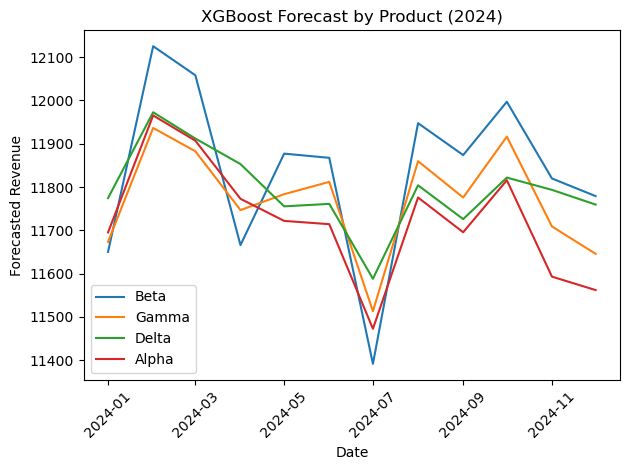

In [154]:
import matplotlib.pyplot as plt

for product in forecast_final['Product'].unique():
    product_data = forecast_final[forecast_final['Product'] == product]
    plt.plot(product_data['Date'], product_data['Final_Forecast'], label=product)

plt.title("XGBoost Forecast by Product (2024)")
plt.xlabel("Date")
plt.ylabel("Forecasted Revenue")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

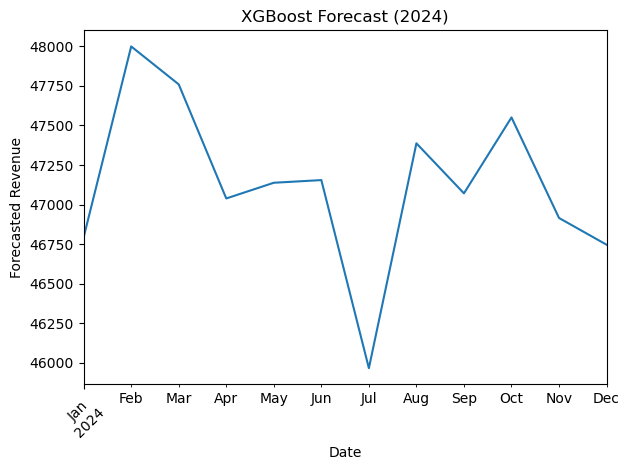

In [155]:
grouped_products = forecast_final.groupby('Date')['Final_Forecast'].sum()
grouped_products.plot()

plt.title("XGBoost Forecast (2024)")
plt.ylabel("Forecasted Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> **Disclaimer – Forecast Prototype**
> This notebook extends the baseline and residual models to *prototype* a 2024 forecast.  
> Feature values for future months use averaged or seasonally templated inputs (e.g., average Unit_Price / Units_Sold), so absolute forecast levels here are **placeholders**.  
> The notebook’s purpose: produce a *level* series and expose its lack of seasonal variability, motivating the hybrid variance‑restoration and shape-scaling performed in `08_hybrid_forecasts.ipynb`.

## ✅ Final Deliverables

The notebook successfully produced the following:

- 🧠 **Forecast DataFrame** with:
  - `Date`, `Product`, `Final_Forecast` for 2024
- 📁 **CSV Export** ready for Power BI
- ✅ Forecasts aligned with product logic and model behavior

This output enables seamless comparison with Prophet and SARIMA forecasts in Power BI — allowing the business to make more informed decisions for 2024 planning.

In [158]:
# Create and save XGBoost forecast statistics table

# Compute description
desc_stats = grouped_products.describe()

# Convert to DataFrame (for saving with labels)
desc_df = desc_stats.to_frame(name='XGBoost_Forecast')

# Optional: reset index for better CSV layout
desc_df.reset_index(inplace=True)
desc_df.rename(columns={'index': 'Statistic'}, inplace=True)

In [159]:
def maybe_save(df: pd.DataFrame, filename: str):
    """
    Save to scratch_outputs/ only if SAVE_OUTPUTS is True.
    Prevents overwriting the canonical CSVs in data/processed/.
    """
    if SAVE_OUTPUTS:
        df.to_csv(EXPORT_DIR / filename, index=False)
        print(f"🔸 Saved {filename} to {EXPORT_DIR}")
    else:
        print(f"⏩ Skipped saving {filename} (SAVE_OUTPUTS = False)")

In [160]:
# Export XGB Forecast Model Statistics
maybe_save(desc_df, "18-XGBoost_Project2_Forecast_Stat.csv")

⏩ Skipped saving 18-XGBoost_Project2_Forecast_Stat.csv (SAVE_OUTPUTS = False)


In [161]:
# Create and save forecast statistics table by product

desc_prod_df = pd.DataFrame()

In [162]:
for product in forecast_final['Product'].unique():
    desc_prod_df[f'{product}'] = forecast_final[forecast_final['Product'] == product]['Final_Forecast'].describe()
    
desc_prod_df.reset_index(inplace=True)
desc_prod_df.rename(columns={'index': 'Statistic'}, inplace=True)    

In [163]:
# Export XGB Forecast Model Product's Statistics

maybe_save(desc_prod_df, "19-Products_XGBoost_Forecast_Stat.csv")

⏩ Skipped saving 19-Products_XGBoost_Forecast_Stat.csv (SAVE_OUTPUTS = False)


In [164]:
#Import Product's Statistics

df_actual = load_processed("17_Products_Actual_Stat.csv").set_index("Statistic")

In [165]:
# Extract the row labeled 'std'
std_actual = df_actual.loc['std']

In [166]:
desc_prod_df = desc_prod_df.set_index('Statistic')
std_forecast = desc_prod_df.loc['std']

In [167]:
std_actual = df_actual.loc['std']

In [168]:
comparison_df = pd.DataFrame({
    'Product': std_actual.index,
    'Actual Std': std_actual.values.round(0).astype(int),
    'Forecast Std': std_forecast.values.round(0).astype(int)
})

In [169]:
comparison_df['Difference'] = comparison_df['Forecast Std'] - comparison_df['Actual Std']

In [170]:
comparison_df

,Product,Actual Std,Forecast Std,Difference
0,Alpha,3573,200,-3373
1,Beta,3753,123,-3630
2,Gamma,3732,96,-3636
3,Delta,4300,139,-4161


In [171]:
# Export XGB Forecast Product Comparison Statistics

maybe_save(comparison_df, "20-Comparison_Product_Stat.csv")

⏩ Skipped saving 20-Comparison_Product_Stat.csv (SAVE_OUTPUTS = False)


In [172]:
columns_for_add = ['Date', 'Month', 'Product','Base_Predicted', 'Final_Forecast']

In [173]:
forecast_add = forecast_full[columns_for_add]

In [174]:
forecast_add.head()

,Date,Month,Product,Base_Predicted,Final_Forecast
0,2024-01-01,1,Beta,11665.258789,11650.265625
1,2024-02-01,2,Beta,12140.188477,12125.195312
2,2024-03-01,3,Beta,12073.082031,12058.088867
3,2024-04-01,4,Beta,11681.029297,11666.036133
4,2024-05-01,5,Beta,11884.633789,11877.171875


In [175]:
# Export XGB Product's Forecast
maybe_save(forecast_add, "21-XGBoost_Product_Forecast_add.csv")

⏩ Skipped saving 21-XGBoost_Product_Forecast_add.csv (SAVE_OUTPUTS = False)
